# **Lab 2: การแสดงผลข้อมูลเชิงพื้นที่ด้วย GeoPandas, Matplotlib, Folium และการวิเคราะห์ข้อมูล Raster ด้วย Rasterio  กรณีศึกษา จังหวัดเพชรบุรี

### 3.1 การโหลดและเตรียมข้อมูล

In [85]:
!pip install geopandas rasterio folium contextily -q

In [86]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import folium
import numpy as np

In [87]:
study_area = gpd.read_file("/content/phetchaburi.shp")
stations = gpd.read_file("/content/station_point.shp")

study_area.head()

,AMP_CODE,PRV_CODE,AMP_NAME_T,AMP_NAME_E,Shape_Leng,TH_Provinc,TH_Provi_1,Shape_Le_1,Shape_Area,geometry
0,7601,76,76,Mueang Phetchaburi,125068.551620,ྪúean,PHETCHABURI,1.053725,0.024012,"POLYGON ((100.08156 13.02482, 100.08022 13.023..."
1,7602,76,76,Khao Yoi,103276.154467,ྪúao,PHETCHABURI,0.866080,0.026420,"POLYGON ((99.88373 13.24666, 99.88326 13.24562..."
2,7603,76,˹ͧ˭3һHAͧ,Nong Ya Plong,323386.054868,ྪúng,PHETCHABURI,2.730025,0.102218,"POLYGON ((99.79564 13.11659, 99.79567 13.11629..."
3,7604,76,76,Cha-Am,133700.657683,ྪúa-A,PHETCHABURI,1.139960,0.043695,"POLYGON ((100.02606 12.91793, 100.02607 12.917..."
4,7605,76,76,Tha Yang,199977.841903,ྪúa Y,PHETCHABURI,1.701502,0.065105,"POLYGON ((99.96336 12.9862, 99.96357 12.98313,..."


In [88]:
study_area.crs
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [89]:
raster = rasterio.open("/content/phetchaburi_LS8_45.tif")
raster.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -inf,
 'width': 6016,
 'height': 4235,
 'count': 2,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32647"]]'),
 'transform': Affine(30.0, 0.0, 473250.0,
        0.0, -30.0, 1488240.0)}

In [90]:
raster.count
raster.crs
raster.res

(30.0, 30.0)

### 3.2 การสร้างแผนที่ข้อมูลเวกเตอร์

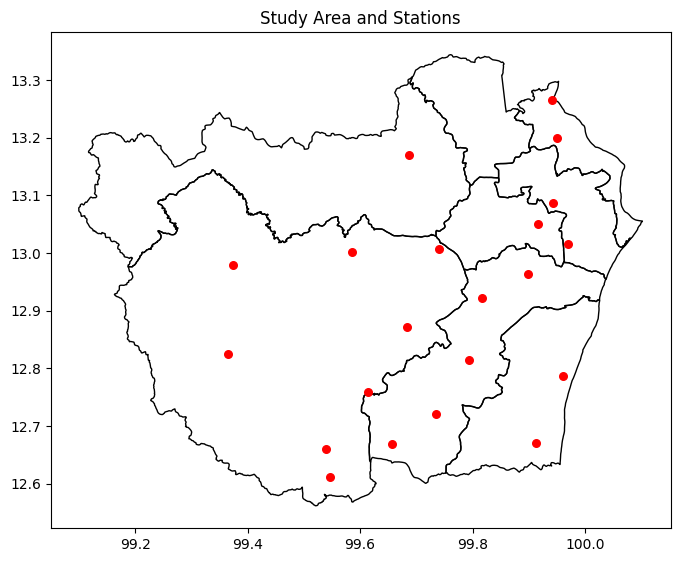

In [91]:
fig, ax = plt.subplots(figsize=(8,8))
study_area.plot(ax=ax, facecolor="none", edgecolor="black")
stations.plot(ax=ax, color="red", markersize=30)
plt.title("Study Area and Stations")
plt.show()

In [92]:
m = folium.Map(location=[
    stations.geometry.y.mean(),
    stations.geometry.x.mean()
], zoom_start=8)

for _, row in stations.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup="Station"
    ).add_to(m)

m

### 3.3 การทำงานกับข้อมูล Raster

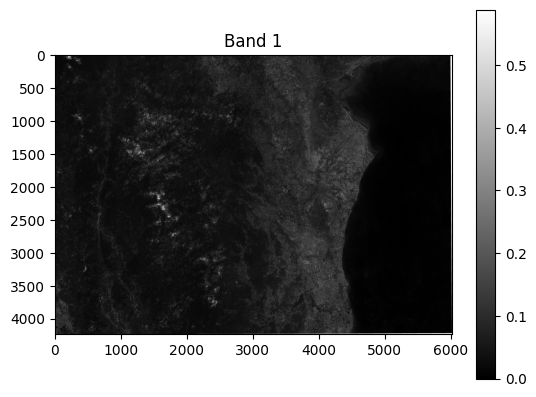

In [93]:
band1 = raster.read(1)

plt.imshow(band1, cmap="gray")
plt.colorbar()
plt.title("Band 1")
plt.show()

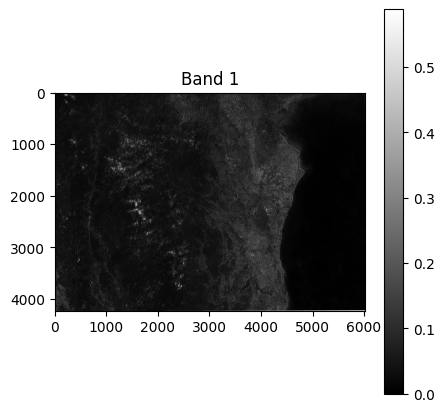

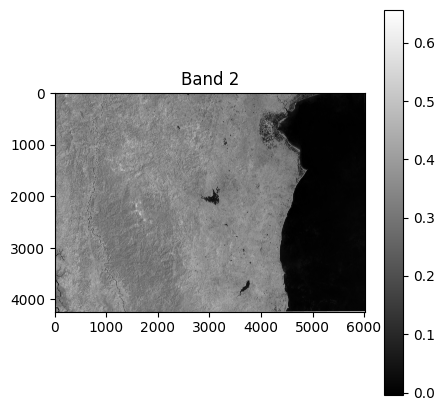

In [101]:
for i in range(1, raster.count + 1):
    plt.figure(figsize=(5,5))
    plt.imshow(raster.read(i), cmap="gray")
    plt.title(f"Band {i}")
    plt.colorbar()
    plt.show()

### คำนวณ NDVI

In [94]:
red = raster.read(1).astype(float)
nir = raster.read(2).astype(float)

ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1)

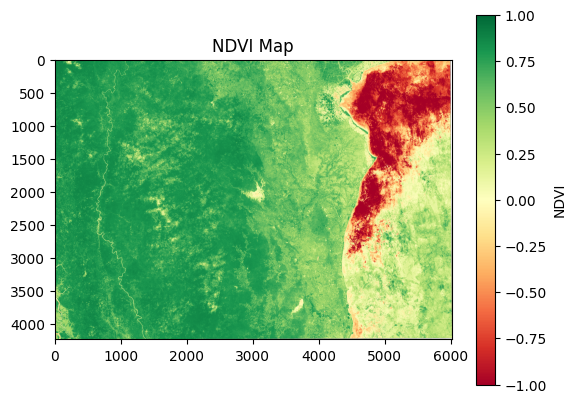

In [95]:
plt.imshow(ndvi, cmap="RdYlGn")
plt.colorbar(label="NDVI")
plt.title("NDVI Map")
plt.show()

### Masking และ Clipping

In [96]:
from rasterio.mask import mask
from shapely.geometry import mapping

# Get the CRS of the raster
raster_crs = raster.crs

# Reproject the study_area to the raster's CRS
study_area_proj = study_area.to_crs(raster_crs)

geoms = [mapping(study_area_proj.geometry.iloc[0])]

clipped, transform = mask(raster, geoms, crop=True)
print("Masking successful!")

Masking successful!


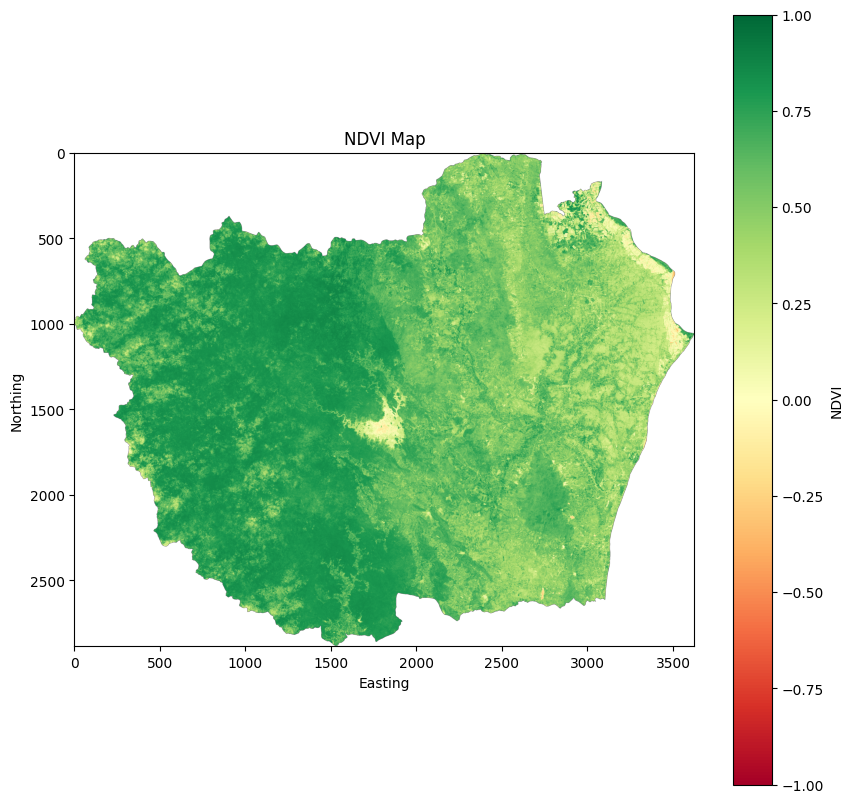

In [97]:
from rasterio.mask import mask as rio_mask
from rasterio.crs import CRS
from rasterio.io import MemoryFile
import numpy as np

# Get the CRS, transform, and other metadata from the original 'raster' object
raster_crs = raster.crs
raster_transform = raster.transform
raster_meta = raster.meta.copy()

# Reproject the 'study_area' (which was 'gdf' in the original problematic code) to the raster's CRS
if study_area.crs != raster_crs:
    study_area_proj = study_area.to_crs(raster_crs)
else:
    study_area_proj = study_area.copy()

# Get the geometries for masking
geoms = [mapping(geom) for geom in study_area_proj.geometry]

# Prepare metadata for the NDVI array, which is a single-band float64 raster
ndvi_meta = raster_meta.copy()
ndvi_meta.update({
    'count': 1, # NDVI is a single band
    'dtype': ndvi.dtype, # Use the dtype of the ndvi array
    'nodata': np.nan # Assuming NaN is used for no data in ndvi
})

# Create an in-memory raster dataset from the ndvi array
with MemoryFile() as memfile:
    with memfile.open(**ndvi_meta) as temp_ndvi_dataset:
        temp_ndvi_dataset.write(ndvi, 1) # Write the ndvi array as the first band

        # Now, use rio_mask with the in-memory dataset
        clipped_ndvi_array, clipped_transform_ndvi = rio_mask(
            temp_ndvi_dataset,
            geoms,
            crop=True,
            nodata=np.nan # Ensure nodata value is consistent
        )

# Update metadata for the clipped NDVI array for potential future use (e.g., writing to file)
clipped_ndvi_meta = ndvi_meta.copy()
clipped_ndvi_meta.update({
    "height": clipped_ndvi_array.shape[1],
    "width":  clipped_ndvi_array.shape[2],
    "transform": clipped_transform_ndvi
})


# Optional: Display the clipped NDVI
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(clipped_ndvi_array[0], cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI Map')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()

### 3.4 การรวมข้อมูลเวกเตอร์และแรสเตอร์ และ 3.5 การแสดงผลข้อมูล

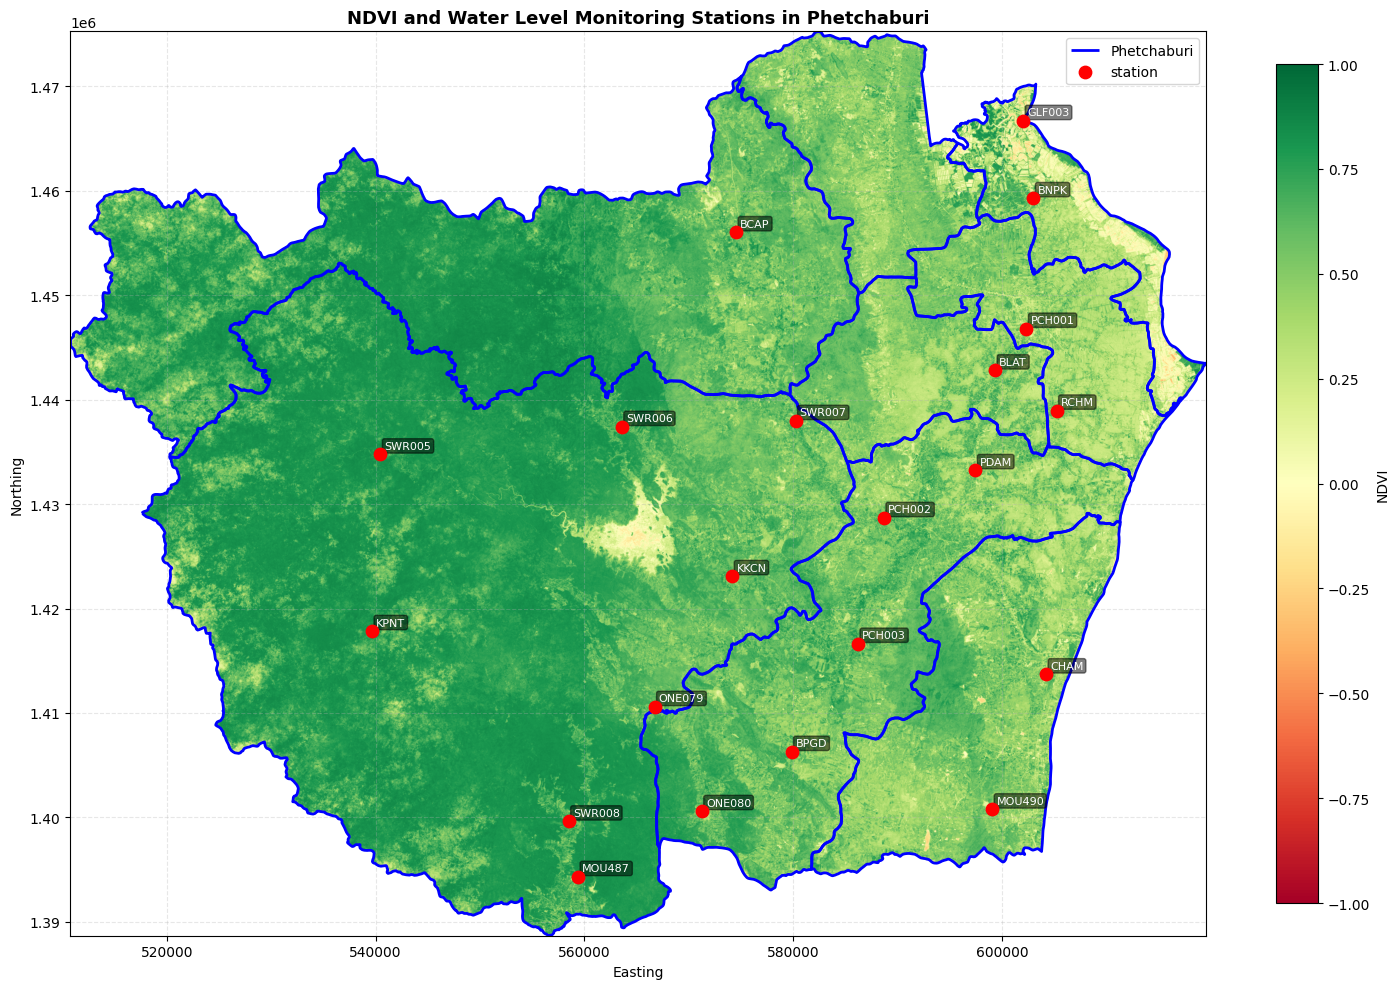

In [98]:
# Calculate extent from clipped_ndvi_meta
left = clipped_ndvi_meta['transform'].xoff
top = clipped_ndvi_meta['transform'].yoff
right = left + clipped_ndvi_meta['width'] * clipped_ndvi_meta['transform'].a
bottom = top + clipped_ndvi_meta['height'] * clipped_ndvi_meta['transform'].e
extent = [left, right, bottom, top]

fig, ax = plt.subplots(figsize=(15, 10))

# Plot clipped NDVI
im = ax.imshow(clipped_ndvi_array[0], cmap='RdYlGn', vmin=-1, vmax=1,
               extent=extent, aspect='auto')
plt.colorbar(im, ax=ax, label='NDVI', fraction=0.03)

# Reproject stations to the same CRS as the raster/clipped_ndvi for correct overlay
stations_proj = stations.to_crs(raster.crs)

# Plot study area boundary (already reprojected to raster_crs in Ou7coZ7qhIPM)
study_area_proj.boundary.plot(ax=ax, color='blue', linewidth=2, label='Phetchaburi')

# Plot stations
stations_proj.plot(ax=ax, color='red', markersize=80, zorder=5, label='station')

# Annotate station names
for _, row in stations_proj.iterrows():
    ax.annotate(row['Station_Co'], xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 4), textcoords='offset points',
                fontsize=8, color='white',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.5))

ax.set_title("NDVI and Water Level Monitoring Stations in Phetchaburi",
             fontsize=13, fontweight='bold')
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("overlay_map.png", dpi=150)
plt.show()

In [99]:
data_to_analyze = clipped_ndvi_array[0]

stats = {
    "Min": np.nanmin(data_to_analyze),
    "Max": np.nanmax(data_to_analyze),
    "Mean": np.nanmean(data_to_analyze),
    "Median": np.nanmedian(data_to_analyze),
    "Std": np.nanstd(data_to_analyze)
}

stats

{'Min': np.float64(-0.4210392902408112),
 'Max': np.float64(0.9138421297718243),
 'Mean': np.float64(0.6224202242927118),
 'Median': np.float64(0.6524601960960692),
 'Std': np.float64(0.1801751865691974)}

In [100]:
for k, v in stats.items():
    print(f"{k}: {v:.4f}")

Min: -0.4210
Max: 0.9138
Mean: 0.6224
Median: 0.6525
Std: 0.1802


### 4. คำถามท้าย Lab
1.	ข้อดีและข้อเสียของการใช้ Matplotlib และ Folium ในการแสดงผลข้อมูลเชิงพื้นที่คืออะไร?

คำตอบ:
**Matplotlib**
ข้อดี คือ
ปรับแต่งองค์ประกอบกราฟได้ทุกส่วน (สี, ขนาด, เส้นขอบ), สร้างไฟล์ภาพคุณภาพสูง (PNG, PDF, SVG) ได้ดี
และ ใช้งานร่วมกับ Library อื่นได้ดี เช่น ทำงานร่วมกับ NumPy, Pandas
ข้อเสีย คือ
เป็น Static Maps ไม่สามารถซูมหรือเลื่อนแผนที่แบบโต้ตอบได้
คำตอบ
** Folium **
ข้อดีคือ
Interactive Web Maps สร้างแผนที่แบบโต้ตอบ เข่นซูม, คลิก, ป๊อปอัป ได้ง่าย, สร้างแผนที่ง่าย โค้ดไม่ซับซ้อน และรองรับข้อมูลภูมิศาสตร์ สามารถใส่ Markers, Polygons, และข้อมูลซ้อนทับ (Overlay) ได้หลากหลาย
ข้อเสียคือ
ไม่เหมาะสำหรับข้อมูลขนาดใหญ่ อาจแสดงผลช้าเมื่อมีจุดข้อมูลหนาแน่นเกินไป
และจำเป็นต้องใช้อินเทอร์เน็ต เพื่อโหลดฐานแผนที่

2.	ทำไมเราต้องใช้ Masking และ Clipping ในการวิเคราะห์ข้อมูลภาพถ่ายดาวเทียม?

คำตอบ: Masking ในการ เลือก ค่า pixel ที่ควรใช้ และ ลดnoise Clipping เลือกเฉพาะพื้นที่ศึกษา เพื่อให้ ผลลัพธ์แม่นยำ ประมวลผลเร็ว และตีความได้ถูกต้อง

3.	ค่า NDVI บ่งบอกถึงอะไร? และสามารถใช้ NDVI ในการวิเคราะห์อะไรได้บ้าง?

คำตอบ:
 NDVI คือดัชนีที่บ่งบอกถึงความหนาแน่น ความเขียวขจี และสุขภาพของพืช โดยคำนวณจากการสะท้อนแสงของพืชในย่านคลื่นสีแดง (Red) และอินฟราเรดใกล้ (NIR) มีค่าระหว่าง -1 ถึง 1 หากเข้าใกล้ 1 แสดงว่าพืชแข็งแรงหนาแน่น ค่าต่ำ (ใกล้ 0) คือพืชอ่อนแอหรือดิน

4.	การแปลงค่าพิกัด (CRS) มีความสำคัญอย่างไรในการทำงานกับข้อมูลเวกเตอร์และแรสเตอร์?

คำตอบ:
เพื่อให้ข้อมูลจากแหล่งที่แตกต่างกันสามารถแสดงผล ซ้อนทับ และวิเคราะห์ร่วมกันได้อย่างถูกต้องตรงตำแหน่งบนพื้นโลก ลดความคลาดเคลื่อนของพื้นที่และหน่วยวัด ช่วยให้การคำนวณระยะทาง พื้นที่ หรือการวิเคราะห์เชิงพื้นที่ (Spatial Analysis) มีความแม่นยำสูง

5.	หากต้องการวิเคราะห์ข้อมูลภาพถ่ายดาวเทียมในช่วงเวลาต่าง ๆ (Time Series) ควรทำอย่างไร?

คำตอบ: 1) เลือกภาพถ่ายดาวเทียมจากแหล่งเดียวกันในหลายช่วงเวลา 2)คำนวณค่า NDVI ของแต่ละช่วงเวลา 3) ตัดข้อมูลให้ตรงกับพื้นที่ศึกษา และ 4) คำนวณค่าสถิติเช่นค่าเฉลี่ย NDVI ในแต่ละช่วงเวลา เพื่อนำมาวิเคราะห์แนวโน้มและการเปลี่ยนแปลงของพืชพรรณตามเวลา


ข้อมูลทีใช้
1. ขอบเขตพื้นที่การศึกษา csuwan.weebly.com. (n.d.). E-PORTAL — ดาวน์โหลดข้อมูล GIS [เว็บเพจ]. Weebly. https://csuwan.weebly.com/360436343623360936603650362736213604--download.html
2. ข้อมูลตำแหน่งสถานีวัดระดับน้ำฝน Open Government Data Portal (Data.go.th). (2026). ระดับน้ำ [Water level dataset]. สถาบันสารสนเทศทรัพยากรน้ำ (องค์การมหาชน).  https://gdcatalog.go.th/dataset/gdpublish-water-level
3. ภาพถ่ายจากดาวเทียม Landsat 8 Level 2, Collection 2, Tier 1 ความละเอียดเชิงพื้นที่ 30 เมตร ณ ช่วงเวลา ค.ศ. 2024 -  ค.ศ. 2025 จาก Google Earth Engine